# Will it be an early Spring?

On February 2<sup>nd</sup> every year Punxsutawney Phil makes a prediction about if there will be an early Spring or if Winter will continue for 6 more weeks (till about mid-March). He is however not very accurate (well, according to [The Inner Circle](https://www.groundhog.org/inner-circle) he is 100% correct but the human handler may not interpret his response correctly). The overall goal is to be able to predict if it will be an early Spring.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself).

Each group from 200-level and 300-level sections with the best results on the 10% of the data that I kept for myself will earn +5 extra credit (if multiple groups are close points may be given to multiple groups).

# Frame the Problem
Since this is a prediction problem, we think that it is a supervised classification with offline learning.
Should be measured with precision to keep only positives.

The client wants this machine learning algorithm in order to seel their new product, which is a varitety of corn that grows faster than standard corn. They want PA to grow the corn, and if there is an early spring, then farmers should be able to get two complete harvests of corn in the growing season. There is a lot of research and development involved with this product, so they are more expensive, making farmers more reluctant to buy the seeds. Because of this, the client wants be able to confidently sell more bundles of seed. Otherwise they will purchase the seeds back from the farmers. The program will be offered with no risk to encourage product usage. Over the winter break, they hired an intern to gather all the weather data from January 1st to February 2nd. February 3rd would be the program announcement. The data ranges from 1947 to 2021, and includes the first 33 days of weather. They will rarely be adding to the data, so there is no need for it to be online. 


## Get the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier

In [2]:
# This data loads all csv files, converts all dates to datetimes, and adds year, month, and day columns to replace those dates. It also pivots the dataframe and merges it with the tartet feature, spring data,
# and phils prediction data

def load_data():
    # loads all csv files
    weather_data = pd.read_csv('weather.csv')
    spring_data = pd.read_csv('early_spring.csv')
    phil_pred_data = pd.read_csv('phil_pred.csv')

    # converts the date column to a datetime. Then it creates year, month, and day columns
    weather_data['date'] = pd.to_datetime(weather_data['date'])
    weather_data['year'] = weather_data['date'].dt.year
    weather_data['month'] = weather_data['date'].dt.month
    weather_data['day'] = weather_data['date'].dt.day

    # takes the 2 days of the second month, and adds them to the first month to simplify the data
    for i in range(len(weather_data['month'])):
        if weather_data['month'][i] == 2:
            if weather_data['day'][i] == 1:
                weather_data['day'][i] = weather_data['day'][i-1] + 1
            else:
                weather_data['day'][i] = weather_data['day'][i-1] + 2

    # Separated data that is pivoted by the year and day
    weather_data = weather_data.sort_values(by='date')
    # Drops 'date' column since it becomes irrelevant because of year, month, and day columns
    weather_data.drop('date', axis=1, inplace=True)

    # Drops year 2001 row since it contains a bunch of nans
    weather_data.drop(weather_data[weather_data['year'] == 2001].index, axis=0, inplace=True)

    # dataframe is pivoted, the column names are made more readable/usable, and the spring data and phil prediction data is merged
    weather_pivoted = weather_data.copy()
    weather_pivoted = weather_data.pivot(index='year', columns=['day'])
    weather_pivoted.columns = [ '_'.join(str(x) for x in y) for y in weather_pivoted.columns.to_flat_index() ]
    weather_pivoted = weather_pivoted.merge(spring_data, on='year', how='left')
    weather_pivoted = weather_pivoted.merge(phil_pred_data, on='year', how='left')
    weather_pivoted.sort_index()

    weather_data = weather_data.merge(spring_data, on='year', how='left')
    weather_data = weather_data.merge(phil_pred_data, on='year', how='left')
    weather_data.sort_index()

    return weather_pivoted, weather_data

def split_labels(data, label_feature):
    """
    Split the given column of of the data, returning the full data set (without that
    feature) and the split off feature.
    """
    return data.drop(columns=label_feature), data[label_feature]

def replace_nan_avg(data):
  '''
  Replaces 'nan' values with the means of its column.
  '''
  data.fillna(data.mean(), inplace=True)
  return data  

In [3]:
class NumpyArrayToPandasDataFrame(BaseEstimator, TransformerMixin):
    """
    This class takes a numpy array as well as a list of indexes and column names to transform 
    a numpy array back into a pandas dataframe during within a pipeline.
    """
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        self.indexes = X.index
        self.columns = X.columns
        X_new = self.transformer.transform(X)

        if not isinstance(X_new, pd.DataFrame):
            return pd.DataFrame(X_new, index=self.indexes[:X.shape[0]], columns=self.columns[:X.shape[1]])
        else:
            self.indexes = X.index
            self.columns = X.columns
            return X


class RemoveRows(BaseEstimator, TransformerMixin):
    """
    Removes colors by name. The colors are given as a list of names.
    By default this removes nothing.

    This operates during fit() only and not transform().
    """
    def __init__(self, rows=()):
        super().__init__()
        self.rows = rows

    def fit(self, X, y=None, **kwargs):
        # Since we need to change the data X based on the target labels y
        # We need to do work here in fit(). In general avoid this, in most cases it will not work.
        if self.rows:
            to_drop = y[X['year'] == 'year'].index
            X.drop(index=to_drop, inplace=True)
            y.drop(index=to_drop, inplace=True)
        return self

    def transform(self, X): return X  # due to the need for modifying and using the y variable, the work is done above

class ProtectXy(BaseEstimator, TransformerMixin):
    """
    Due to all the sketchy stuff the other transformers do in fit(), we
    need a way to protect the fact that those datasets are constantly
    changing but we don't want to change the global datasets.

    All of this is to work around the limitation that the transform()
    method doesn't have a y parameter...
    """
    def __init__(self):
        super().__init__()
        self.X_ref_ = None
        self.y_ref_ = None

    def fit(self, X, y=None, **kwargs):
        if self.X_ref_ is X and self.y_ref_ is y:
            X._update_inplace(self.X_copy_)
            y._update_inplace(self.y_copy_)
        else:
            self.X_ref_, self.y_ref_ = X, y
            self.X_copy_, self.y_copy_ = X.copy(), y.copy()
        return self

    def transform(self, X): return X  # due to the need for modifying and using the y variable, the work is done above

In [4]:
# Loads data, and splits it into a train and test set
weather_pivoted, weather_data = load_data()
weather_pivoted, pivot_test = train_test_split(weather_pivoted, test_size=0.2, random_state=42)
weather_strat, weather_test = train_test_split(weather_data, test_size=0.2, random_state=42)

/var/folders/ns/jhsc1w3d101cp62xgg0jvvg00000gn/T/ipykernel_4116/1037036997.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data['day'][i] = weather_data['day'][i-1] + 1
/var/folders/ns/jhsc1w3d101cp62xgg0jvvg00000gn/T/ipykernel_4116/1037036997.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data['day'][i] = weather_data['day'][i-1] + 2


# Explore The Data

In [1]:
'''
Data exploration functions
'''

def pivot_by_year_and_day(weather):
    """
    Pivots by yeara and day then splits it so we can visualize data much better.
    """
    weather_pivot = weather.copy()
    weather_pivot = weather_pivot.pivot('year', 'day')
    weather_strat, weather_test = train_test_split(weather_data, test_size=0.2, random_state=42)
    return weather_pivot

def plot_hists(wtf, features, bin, with_weather=False):
    """
    Plots histogram of the provided features, default only shows true's and false's
    """
    curr_subplot = 1

    for feat in features:
        plt.subplot(1, 12, curr_subplot)
        plt.title(str(feat))
        if with_weather:
            wtf[0][feat].hist(bins=bin, density=True, color='r', alpha=0.5);
        wtf[1][feat].hist(bins=bin, density=True, color='g', alpha=0.5);
        wtf[2][feat].hist(bins=bin, density=True, color='y', alpha=0.5);

        curr_subplot += 1

def plot_heats(wtf, features, format_title=' '):
    '''
    Show 3 heatmaps of provided weather, true's and false's
    '''
    plt.figure(figsize=(50, 5))
    for i, (name, data_) in enumerate((("Overall{}".format(format_title), wtf[0]),("True{}".format(format_title), wtf[1]), ("False{}".format(format_title), wtf[2])), 1):
        plt.subplot(1, 9, i)
        plt.title(name)
        sns.heatmap(data_[features].corr(), annot=True, vmin=-1, vmax=1, cmap='seismic')
    plt.tight_layout()

def plot_heats_no_feats(wtf, format_title=' '):
    '''
    Show 3 heatmaps of provided weather, true's and false's
    '''
    plt.figure(figsize=(50, 5))
    for i, (name, data_) in enumerate((("Overall{}".format(format_title), wtf[0]),("True{}".format(format_title), wtf[1]), ("False{}".format(format_title), wtf[2])), 1):
        plt.subplot(1, 9, i)
        plt.title(name)
        sns.heatmap(data_)
    plt.tight_layout()


def extract_true_falses(weather):
    '''
    Extracts true and false data by spring from based weather
    '''
    true_list = weather[weather['early_spring'] == True]
    false_list = weather[weather['early_spring'] == False]

    return true_list, false_list

def scatter_matrix(data, features, alpha):
    pd.plotting.scatter_matrix(data[features], alpha=alpha, figsize=(10,10))

In [25]:
# creates dataframes based on early_spring data true and false values
true_strat, false_strat = extract_true_falses(weather_strat)
true_pivot, false_pivot = extract_true_falses(weather_pivoted)

<Figure size 3240x360 with 0 Axes>

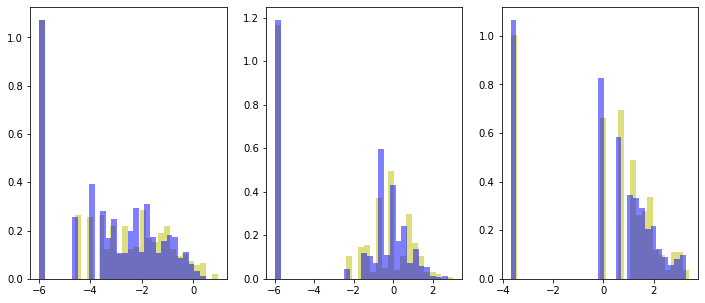

In [29]:
"""
Plot features ['precipitation', 'snowfall', 'snowdepth'] with hist by day for true, false
Clips data since the plots show that all of these features are log normal exponential.
Graphs are done with the dat before pivoting and is done with true and falses for springs from the data.
"""
plt.figure(figsize=(45, 5))
features = ['precipitation', 'snowfall', 'snowdepth']

weather_c = weather_strat.copy()

# weather_c['precipitation'] = np.clip(weather_c['precipitation'], 0, .75)
# weather_c['snowfall'] = np.clip(weather_c['snowfall'], 0, 2)
# weather_c['snowdepth'] = np.clip(weather_c['snowdepth'], 0, 15)

# yellow_nonzero = yellow.loc[yellow["dist"] != 0, "dist"] # we cannot take the log of 0

precip_nonzero = weather_c.loc[weather_c['precipitation'] != 0, 'precipitation']
snowfall_nonzero = weather_c.loc[weather_c['snowfall'] != 0, 'snowfall']
snowdepth_nondepth = weather_c.loc[weather_c['snowdepth'] != 0, 'snowdepth']

tprecip_nonzero = false_strat.loc[false_strat['precipitation'] != 0, 'precipitation']
tsnowfall_nonzero = false_strat.loc[false_strat['snowfall'] != 0, 'snowfall']
tsnowdepth_nondepth = false_strat.loc[false_strat['snowdepth'] != 0, 'snowdepth']

fprecip_nonzero = true_strat.loc[true_strat['precipitation'] != 0, 'precipitation']
fsnowfall_nonzero = true_strat.loc[true_strat['snowfall'] != 0, 'snowfall']
fsnowdepth_nondepth = true_strat.loc[true_strat['snowdepth'] != 0, 'snowdepth']

plt.figure(figsize=(50,5));
plt.subplot(1, 12, 1);
# plt.hist(np.log(precip_nonzero), bins=30, density=True, color='y')
plt.hist(np.log(tprecip_nonzero), bins=30, density=True, color='y', alpha=.5);
plt.hist(np.log(fprecip_nonzero), bins=30, density=True, color='b', alpha=.5);

plt.subplot(1, 12, 2)
# plt.hist(np.log(snowfall_nonzero), bins=30, density=True, color='y')
plt.hist(np.log(tsnowfall_nonzero), bins=30, density=True, color='y', alpha=.5);
plt.hist(np.log(fsnowfall_nonzero), bins=30, density=True, color='b', alpha=.5);

plt.subplot(1, 12, 3)
# plt.hist(np.log(fsnowdepth_nondepth), bins=30, density=True, color='y');
plt.hist(np.log(tsnowdepth_nondepth), bins=30, density=True, color='y', alpha=.5);
plt.hist(np.log(fsnowdepth_nondepth), bins=30, density=True, color='b', alpha=.5);


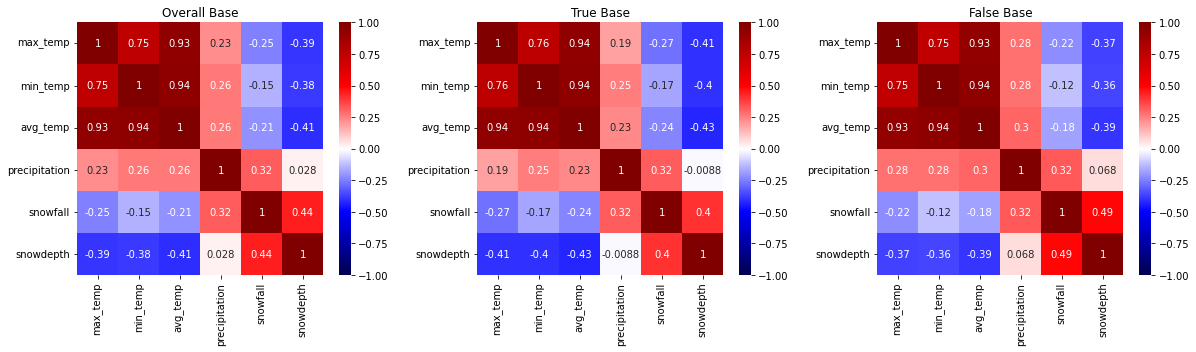

In [31]:
'''
Show correlations without pivoting of each feature. There is heavy correlations through all out however there is a big difference between the precipitation to snowfall precipitation of true and false spring.
'''

features = ['max_temp', 'min_temp', 'avg_temp', 'precipitation', 'snowfall', 'snowdepth']

plot_heats((weather_strat, true_strat, false_strat), features, format_title=' Base')

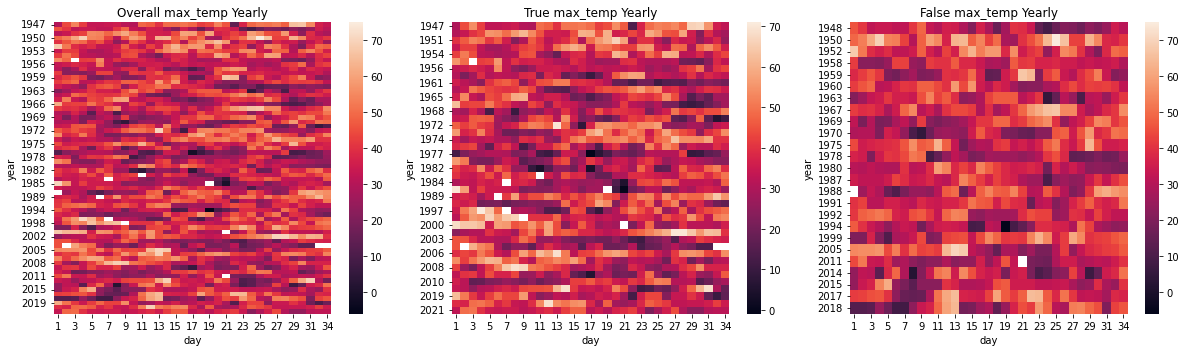

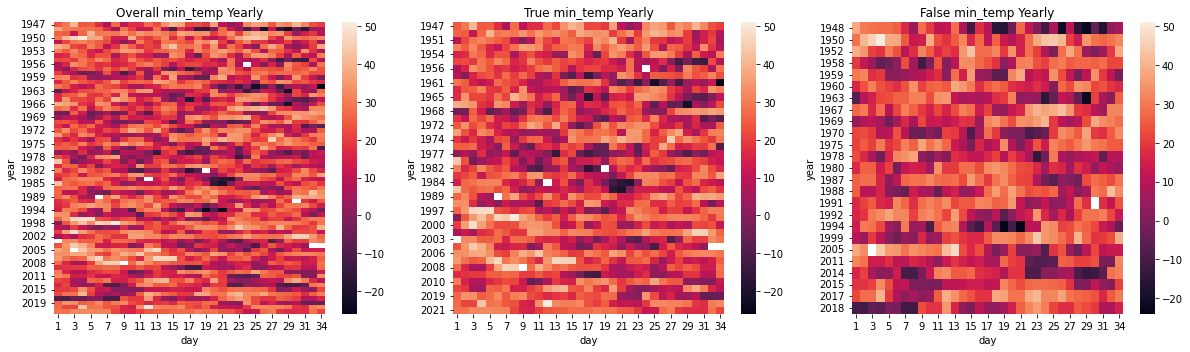

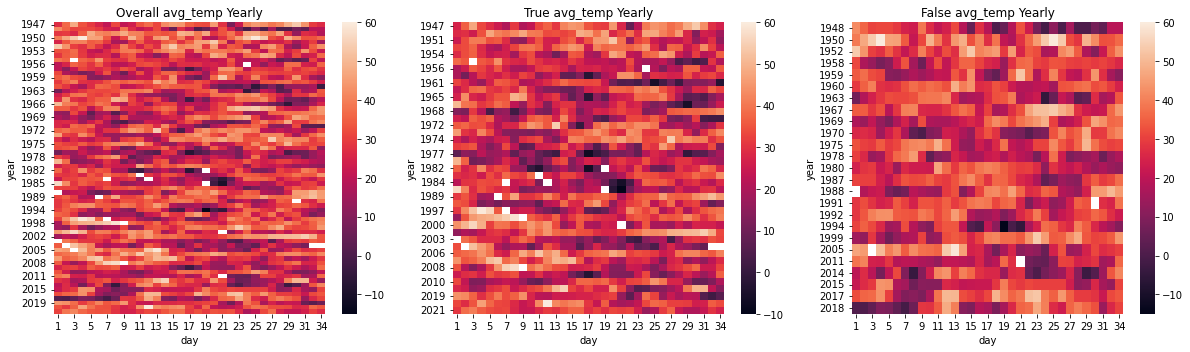

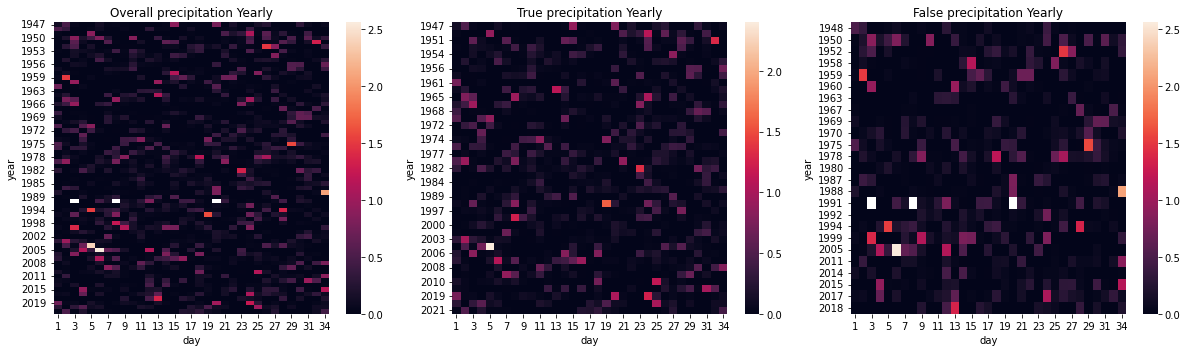

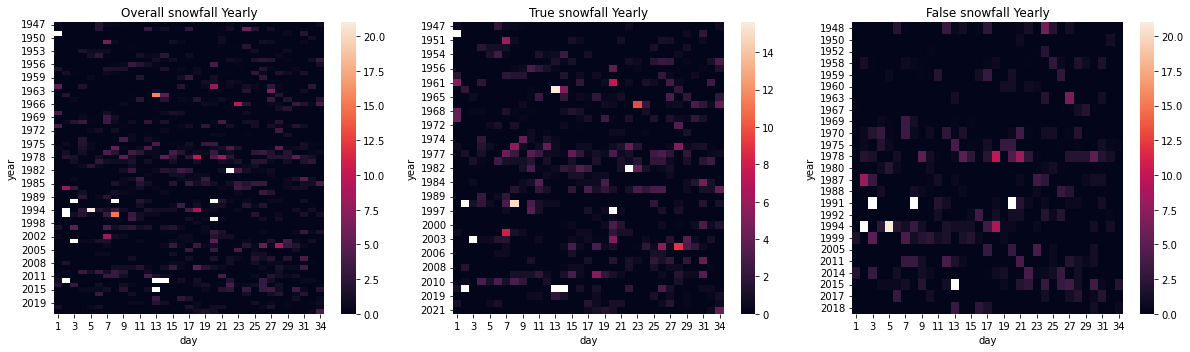

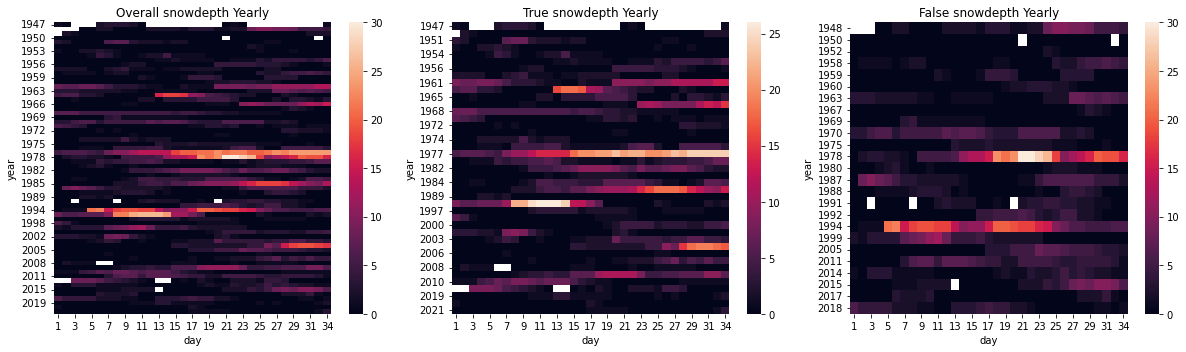

In [52]:
"""
Pivoting the data so we can better visualize the year by day for each day.
The graphs are organized by overall data, data for true early_spring instances separated, and then false early_spring instances separated.
For the false early_spring it tends to have higher precipitations compared to the true early_springs.
However true early_springs have more snowdepth overall compared to false early_springs. This makes sense because more snow early on means less snow later.
"""
features = ['precipitation', 'snowdepth']

weather_pivot = pivot_by_year_and_day(weather_data)

true_piv = weather_pivot[(weather_pivot['early_spring'] == True).any(1)]
false_piv = weather_pivot[(weather_pivot['early_spring'] == False).any(1)]

for feat in features:
    plot_heats_no_feats([weather_pivot[feat].sort_values(by='year'), true_piv[feat].sort_values(by='year'), false_piv[feat].sort_values(by='year')], format_title=" {} Yearly".format(feat))


In [5]:
# gets the avg max temp, min temp, avg temp, precipitation, snowfall, snowdepth of the whole year
feats = ['max_temp', 'min_temp', 'avg_temp', 'precipitation', 'snowfall', 'snowdepth']
for feature in feats:
    cols = [col for col in weather_pivoted.columns if feature in col]
    weather_pivoted['avg_'+feature] = weather_pivoted[cols].sum(axis=1) / len(cols)

## Summary

The overall data was kept before pivoting but also split with the same percentage and random state to insure visualization accuracy. The data was also pivoted differntly to plot each sample by the day of the year for visualizations.

`max_temp`, `min_temp`, and `avg_temp` all have extremely high correlations to one another shared throughout all the overall data, true spring data and false spring data. Which is to be expected.

Interestingly enough, `precipitation` for false early springs has higher correlation across all the features, which is supported by the heatmaps that false early springs have more precipitation.

`snowdepth` for true early spring data is higher overall, as logically it would snow more early on as this would shorten the incoming winter.

The correlations between the true and false early spring data is near the same. However `precipitation` to `snowdepth` correlation for true is much less than the correlation for false.

Despite these findings, there is really nothing dramatic or different to the point where we would need to changes to the data for better performance later on. The data will be kept as is aside from a few changes discussed below.

The `precipitation`, `snowdepth`, and `snowfall` are all log normals. So we would need to get the np.log of each in the pipeline later down and set them to be greater than 1 as we cannot take the log of anything less than 1.

There is not much missing values, however we will fill in the values nonetheless for each feature.

# Prepare the Data

In [5]:
# Splits the target label from the data (target is 'early_spring')
# prediction is removed to keep out phils incorrect predictions
weather_pivoted.drop('prediction', axis=1, inplace=True)
X, y = split_labels(weather_pivoted, 'early_spring')

In [6]:
# Gets the log of a feature, and adds one to prevent -inf errors
def log_plus_one(data):
    return np.log(data + 1)

# Creates the preprocessor to transform the data
preprocessor = Pipeline([
  # keeps the scores from to get corrupted by fit methods
  ('protect', ProtectXy()),
  # imputes the missing values by getting nearest neighbors around them
  ('imputer', NumpyArrayToPandasDataFrame(KNNImputer())),
  # get the log transforms of the precipitation, snowfall, and snowdepth columns
  ('log_transform', NumpyArrayToPandasDataFrame(ColumnTransformer([
    ('log_precipitation', FunctionTransformer(log_plus_one), [f'precipitation_{i}' for i in range(1, 33)]), 
    ('log_snowfall', FunctionTransformer(log_plus_one), [f'snowfall_{i}' for i in range(1, 33)]),
    ('log_snowdepth', FunctionTransformer(log_plus_one), [f'snowdepth_{i}' for i in range(1, 33)]),
  ], remainder='passthrough'))),
  # scales the data
  ('scaler', NumpyArrayToPandasDataFrame(StandardScaler())),
])

data_prepped = preprocessor.fit(X, y)
data_prepped

Pipeline(steps=[('protect', ProtectXy()),
                ('imputer',
                 NumpyArrayToPandasDataFrame(transformer=KNNImputer())),
                ('log_transform',
                 NumpyArrayToPandasDataFrame(transformer=ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('log_precipitation',
                                                                                          FunctionTransformer(func=<function log_plus_one at 0x10c309280>),
                                                                                          ['precipitation_1',
                                                                                           'precipitation_2',
                                                                                           'precipitat...
                                                                                           'snowdepth_13',
                       

# Short-List Promising Models

In [7]:
# Decision Tree Classifier
dtc= Pipeline(steps=[
('preprocessor', preprocessor),
('DecisionTreeClassifier', DecisionTreeClassifier()),
])
dtc.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, dtc.predict(X)), cross_val_score(dtc, X, y, scoring='accuracy', cv=3)

y_pred_decision = cross_val_predict(dtc, X, y)
accuracy_radius = accuracy_score(y, y_pred_decision)
metric_radius = precision_score(y, y_pred_decision)
accuracy_radius, metric_radius

(0.5, 0.6)

In [8]:
# SGD Classifier
sgd = Pipeline(steps=[
('preprocessor', preprocessor),
('SGD_Classifier', SGDClassifier())
])
sgd.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, sgd.predict(X)), cross_val_score(sgd, X, y, scoring='accuracy', cv=3)

y_pred_sgd = cross_val_predict(sgd, X, y)
accuracy_radius = accuracy_score(y, y_pred_sgd)
metric_radius = precision_score(y, y_pred_sgd)
accuracy_radius, metric_radius

(0.5961538461538461, 0.6875)

In [9]:
# Random Forest Classifier
rfc = Pipeline(steps=[
('preprocessor', preprocessor),
('RandomTree_Classifier', RandomForestClassifier())
])

rfc.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, rfc.predict(X)), cross_val_score(rfc, X, y, scoring='accuracy', cv=3)

y_pred_random = cross_val_predict(rfc, X, y)
accuracy_radius = accuracy_score(y, y_pred_random)
metric_radius = precision_score(y, y_pred_random)
accuracy_radius, metric_radius

(0.5769230769230769, 0.627906976744186)

In [10]:
# Etra-Trees Classifier
etc = Pipeline(steps=[
('preprocessor', preprocessor),
('ExtraTree_Classifier', ExtraTreesClassifier())
])
etc.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, etc.predict(X)), cross_val_score(etc, X, y, scoring='accuracy', cv=3)

y_pred_extra = cross_val_predict(etc, X, y)
accuracy_radius = accuracy_score(y, y_pred_extra)
metric_radius = precision_score(y, y_pred_extra)
accuracy_radius, metric_radius

(0.5961538461538461, 0.6363636363636364)

In [11]:
# Ada BoostClassifier
ada_boost_clf = Pipeline(steps=[
('preprocessor', preprocessor),
('Ada_Boost_Classifier', AdaBoostClassifier())
])

ada_boost_clf.fit(X, y)
accuracy_score(y, ada_boost_clf.predict(X)), cross_val_score(ada_boost_clf, X, y, scoring='accuracy', cv=3)

y_pred_ada = cross_val_predict(ada_boost_clf, X, y)
accuracy_radius = accuracy_score(y, y_pred_ada)
metric_radius = precision_score(y, y_pred_ada)
accuracy_radius, metric_radius

(0.5, 0.6)

# Fine-Tune the System

In [ ]:
dtc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'DecisionTreeClassifier', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__imputer', 'preprocessor__scaler', 'preprocessor__imputer__transformer__add_indicator', 'preprocessor__imputer__transformer__copy', 'preprocessor__imputer__transformer__metric', 'preprocessor__imputer__transformer__missing_values', 'preprocessor__imputer__transformer__n_neighbors', 'preprocessor__imputer__transformer__weights', 'preprocessor__imputer__transformer', 'preprocessor__scaler__transformer__copy', 'preprocessor__scaler__transformer__with_mean', 'preprocessor__scaler__transformer__with_std', 'preprocessor__scaler__transformer', 'DecisionTreeClassifier__ccp_alpha', 'DecisionTreeClassifier__class_weight', 'DecisionTreeClassifier__criterion', 'DecisionTreeClassifier__max_depth', 'DecisionTreeClassifier__max_features', 'DecisionTreeClassifier__max_leaf_nodes', 'DecisionTreeClassifier__min_impurity_decrease', 'Decis

In [14]:
# Grid search
DecisionTreeClassifier()
search_dt = GridSearchCV(
    dtc, [{ 'DecisionTreeClassifier__criterion': ['gini', 'entropy'], 
            'DecisionTreeClassifier__splitter': ['best', 'random'],
            'DecisionTreeClassifier__max_depth': [2, 4, 6, 8, 10], 
            'DecisionTreeClassifier__min_samples_leaf': [8, 10, 12],
            'DecisionTreeClassifier__max_features': [None, 75, 100, 125],
            'DecisionTreeClassifier__min_impurity_decrease': [0.1, 0.5, 1],
        }],
    cv=3, scoring='precision', n_jobs=-1
)

search_dt.fit(X, y)
search_dt.best_params_, search_dt.best_score_

({'DecisionTreeClassifier__criterion': 'entropy',
  'DecisionTreeClassifier__max_depth': 4,
  'DecisionTreeClassifier__max_features': None,
  'DecisionTreeClassifier__min_impurity_decrease': 0.1,
  'DecisionTreeClassifier__min_samples_leaf': 12,
  'DecisionTreeClassifier__splitter': 'random'},
 0.7490196078431373)

In [ ]:
sgd.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'SGD_Classifier', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__imputer', 'preprocessor__scaler', 'preprocessor__imputer__transformer__add_indicator', 'preprocessor__imputer__transformer__copy', 'preprocessor__imputer__transformer__fill_value', 'preprocessor__imputer__transformer__missing_values', 'preprocessor__imputer__transformer__strategy', 'preprocessor__imputer__transformer__verbose', 'preprocessor__imputer__transformer', 'preprocessor__scaler__transformer__copy', 'preprocessor__scaler__transformer__with_mean', 'preprocessor__scaler__transformer__with_std', 'preprocessor__scaler__transformer', 'SGD_Classifier__alpha', 'SGD_Classifier__average', 'SGD_Classifier__class_weight', 'SGD_Classifier__early_stopping', 'SGD_Classifier__epsilon', 'SGD_Classifier__eta0', 'SGD_Classifier__fit_intercept', 'SGD_Classifier__l1_ratio', 'SGD_Classifier__learning_rate', 'SGD_Classifier__loss', 'SGD_Cla

In [16]:
# Grid search
SGDClassifier()
search_sgd = GridSearchCV(
    sgd, [{
        'SGD_Classifier__eta0': [0.1, 0.5, 1],
        'SGD_Classifier__loss': ['hinge', 'squared_hinge'], 
        'SGD_Classifier__n_iter_no_change': [20, 30, 40],
        'SGD_Classifier__max_iter': [500, 600, 700], 
        'SGD_Classifier__early_stopping': [True, False],
        'SGD_Classifier__shuffle': [True, False],
        'SGD_Classifier__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'SGD_Classifier__warm_start': [True, False],
    }],
    cv=3, scoring='precision', n_jobs=-1
)

search_sgd.fit(X, y)
search_sgd.best_params_, search_sgd.best_score_

({'SGD_Classifier__early_stopping': True,
  'SGD_Classifier__eta0': 0.5,
  'SGD_Classifier__learning_rate': 'optimal',
  'SGD_Classifier__loss': 'squared_hinge',
  'SGD_Classifier__max_iter': 600,
  'SGD_Classifier__n_iter_no_change': 40,
  'SGD_Classifier__shuffle': True,
  'SGD_Classifier__warm_start': True},
 0.85)

In [50]:
rfc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'RandomTree_Classifier', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__protect', 'preprocessor__imputer', 'preprocessor__scaler', 'preprocessor__imputer__transformer__add_indicator', 'preprocessor__imputer__transformer__copy', 'preprocessor__imputer__transformer__metric', 'preprocessor__imputer__transformer__missing_values', 'preprocessor__imputer__transformer__n_neighbors', 'preprocessor__imputer__transformer__weights', 'preprocessor__imputer__transformer', 'preprocessor__scaler__transformer__copy', 'preprocessor__scaler__transformer__with_mean', 'preprocessor__scaler__transformer__with_std', 'preprocessor__scaler__transformer', 'RandomTree_Classifier__bootstrap', 'RandomTree_Classifier__ccp_alpha', 'RandomTree_Classifier__class_weight', 'RandomTree_Classifier__criterion', 'RandomTree_Classifier__max_depth', 'RandomTree_Classifier__max_features', 'RandomTree_Classifier__max_leaf_nodes', '

In [ ]:
# Grid search
search_random = GridSearchCV(
    rfc, [{
        'RandomTree_Classifier__n_estimators': [25, 50, 100, 500], 
        'RandomTree_Classifier__criterion': ['gini', 'entropy'],
        'RandomTree_Classifier__max_depth': [None, 1, 5, 10],
        'RandomTree_Classifier__warm_start': [True, False],
        'RandomTree_Classifier__min_impurity_decrease': [0, 1, 5],
        'RandomTree_Classifier__bootstrap': [True, False],
        }],
    cv=3, scoring='precision', n_jobs=-1, verbose=2
)

search_random.fit(X, y)
search_random.best_params_, search_random.best_score_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END RandomTree_Classifier__bootstrap=True, RandomTree_Classifier__criterion=gini, RandomTree_Classifier__max_depth=None, RandomTree_Classifier__min_impurity_decrease=0, RandomTree_Classifier__n_estimators=50, RandomTree_Classifier__warm_start=True; total time=   0.3s
[CV] END RandomTree_Classifier__bootstrap=True, RandomTree_Classifier__criterion=gini, RandomTree_Classifier__max_depth=None, RandomTree_Classifier__min_impurity_decrease=0, RandomTree_Classifier__n_estimators=50, RandomTree_Classifier__warm_start=True; total time=   0.3s
[CV] END RandomTree_Classifier__bootstrap=True, RandomTree_Classifier__criterion=gini, RandomTree_Classifier__max_depth=None, RandomTree_Classifier__min_impurity_decrease=0, RandomTree_Classifier__n_estimators=50, RandomTree_Classifier__warm_start=True; total time=   0.3s
[CV] END RandomTree_Classifier__bootstrap=True, RandomTree_Classifier__criterion=gini, RandomTree_Classifier__max_dept

({'RandomTree_Classifier__bootstrap': False,
  'RandomTree_Classifier__criterion': 'entropy',
  'RandomTree_Classifier__max_depth': None,
  'RandomTree_Classifier__min_impurity_decrease': 0,
  'RandomTree_Classifier__n_estimators': 100,
  'RandomTree_Classifier__warm_start': True},
 0.7222222222222222)

In [55]:
etc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'ExtraTree_Classifier', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__protect', 'preprocessor__imputer', 'preprocessor__scaler', 'preprocessor__imputer__transformer__add_indicator', 'preprocessor__imputer__transformer__copy', 'preprocessor__imputer__transformer__metric', 'preprocessor__imputer__transformer__missing_values', 'preprocessor__imputer__transformer__n_neighbors', 'preprocessor__imputer__transformer__weights', 'preprocessor__imputer__transformer', 'preprocessor__scaler__transformer__copy', 'preprocessor__scaler__transformer__with_mean', 'preprocessor__scaler__transformer__with_std', 'preprocessor__scaler__transformer', 'ExtraTree_Classifier__bootstrap', 'ExtraTree_Classifier__ccp_alpha', 'ExtraTree_Classifier__class_weight', 'ExtraTree_Classifier__criterion', 'ExtraTree_Classifier__max_depth', 'ExtraTree_Classifier__max_features', 'ExtraTree_Classifier__max_leaf_nodes', 'ExtraTre

In [ ]:
# Grid search
search_extra = GridSearchCV(
    etc, [{
        'ExtraTree_Classifier__n_estimators': [20, 25, 30], 
        'ExtraTree_Classifier__criterion': ['gini', 'entropy'],
        'ExtraTree_Classifier__max_depth': [None, 1, 5, 10],
        'ExtraTree_Classifier__warm_start': [True, False],
        'ExtraTree_Classifier__min_impurity_decrease': [0, 1, 5],
        'ExtraTree_Classifier__bootstrap': [True, False],
        }],
    cv=3, scoring='precision', n_jobs=-1, verbose=2
)

search_extra.fit(X, y)
search_extra.best_params_, search_extra.best_score_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END ExtraTree_Classifier__bootstrap=True, ExtraTree_Classifier__criterion=gini, ExtraTree_Classifier__max_depth=None, ExtraTree_Classifier__min_impurity_decrease=0, ExtraTree_Classifier__n_estimators=20, ExtraTree_Classifier__warm_start=True; total time=   0.3s
[CV] END ExtraTree_Classifier__bootstrap=True, ExtraTree_Classifier__criterion=gini, ExtraTree_Classifier__max_depth=None, ExtraTree_Classifier__min_impurity_decrease=0, ExtraTree_Classifier__n_estimators=20, ExtraTree_Classifier__warm_start=False; total time=   0.3s
[CV] END ExtraTree_Classifier__bootstrap=True, ExtraTree_Classifier__criterion=gini, ExtraTree_Classifier__max_depth=None, ExtraTree_Classifier__min_impurity_decrease=0, ExtraTree_Classifier__n_estimators=20, ExtraTree_Classifier__warm_start=True; total time=   0.4s
[CV] END ExtraTree_Classifier__bootstrap=True, ExtraTree_Classifier__criterion=gini, ExtraTree_Classifier__max_depth=None, ExtraTree_Cl

({'ExtraTree_Classifier__bootstrap': True,
  'ExtraTree_Classifier__criterion': 'gini',
  'ExtraTree_Classifier__max_depth': 10,
  'ExtraTree_Classifier__min_impurity_decrease': 0,
  'ExtraTree_Classifier__n_estimators': 25,
  'ExtraTree_Classifier__warm_start': False},
 0.7168803418803419)

In [61]:
ada_boost_clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'Ada_Boost_Classifier', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__protect', 'preprocessor__imputer', 'preprocessor__scaler', 'preprocessor__imputer__transformer__add_indicator', 'preprocessor__imputer__transformer__copy', 'preprocessor__imputer__transformer__metric', 'preprocessor__imputer__transformer__missing_values', 'preprocessor__imputer__transformer__n_neighbors', 'preprocessor__imputer__transformer__weights', 'preprocessor__imputer__transformer', 'preprocessor__scaler__transformer__copy', 'preprocessor__scaler__transformer__with_mean', 'preprocessor__scaler__transformer__with_std', 'preprocessor__scaler__transformer', 'Ada_Boost_Classifier__algorithm', 'Ada_Boost_Classifier__base_estimator', 'Ada_Boost_Classifier__learning_rate', 'Ada_Boost_Classifier__n_estimators', 'Ada_Boost_Classifier__random_state'])

In [ ]:
# Grid search
AdaBoostClassifier()
search_ada_boost = GridSearchCV(
    ada_boost_clf, [{
        'Ada_Boost_Classifier__algorithm': ['SAMME', 'SAMME.R'], 
        'Ada_Boost_Classifier__learning_rate': [1.5, 1.7, 2],
        'Ada_Boost_Classifier__n_estimators': [25, 50, 100, 500],
        }],
    cv=3, scoring='precision', n_jobs=-1, verbose=2
)

search_ada_boost.fit(X, y)
search_ada_boost.best_params_, search_ada_boost.best_score_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=25; total time=   0.2s[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=25; total time=   0.2s

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=25; total time=   0.2s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=50; total time=   0.3s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=50; total time=   0.3s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=50; total time=   0.3s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.fra

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=25; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.fra

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=50; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.fra

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=50; total time=   1.1s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=500; total time=   4.7s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=50; total time=   0.9s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=500; total time=   5.1s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.5, Ada_Boost_Classifier__n_estimators=500; total time=   5.2s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=100; total time=   0.9s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_e

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.fra

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=2, Ada_Boost_Classifier__n_estimators=25; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.fra

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=2, Ada_Boost_Classifier__n_estimators=50; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.fra

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=2, Ada_Boost_Classifier__n_estimators=50; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Library/Frameworks/Python.fra

[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=2, Ada_Boost_Classifier__n_estimators=50; total time=   0.6s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=500; total time=   3.7s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=500; total time=   3.9s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=1.7, Ada_Boost_Classifier__n_estimators=500; total time=   4.0s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=2, Ada_Boost_Classifier__n_estimators=100; total time=   1.1s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=2, Ada_Boost_Classifier__n_estimators=100; total time=   1.2s
[CV] END Ada_Boost_Classifier__algorithm=SAMME, Ada_Boost_Classifier__learning_rate=2, Ada_Boost_Classifier__n_estimato

({'Ada_Boost_Classifier__algorithm': 'SAMME',
  'Ada_Boost_Classifier__learning_rate': 2,
  'Ada_Boost_Classifier__n_estimators': 50},
 0.7027417027417027)

# Final Model

In [17]:
model =  search_sgd
test_X, test_y = split_labels(pivot_test, "early_spring")
test_X.drop('prediction', axis=1, inplace=True)
y_test_pred = model.predict(test_X)

In [18]:
metric = precision_score(test_y, y_test_pred)
metric

0.625

In [19]:
import pickle
with open('model.pkl', 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

# Present Your Solution

Your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

We used precision as our metric, because we felt the client would want to keep out false positives that would threaten their guarantee program. 

In this data, we didn't find many correlations. We also split the true and false early_spring to so we can visualize and compare the data better. There was a possibility between precipitation and snowdepth between true and false correlations (as they were the only thing in our findings different), but it was not prominent enough for us to soley use those features. We used clipping, log transforms, and tried to find correlations between the data and the true and false early springs, and tried adding features that were an average for each of the numerical features.  We also removed columns that were filled with mainly NaNs.

For the preprocessor, we believed that imputing, logging, and scaling the data was the best course of action for transforming the data. 

The Models we looked at in Short-Listing were DecisionTrees, SGDClassifier, RandomForestClassifier, ExtraTreesClassifier, and AdaBoostClassifier. We originally were trying to use VotingClassifier instead of AdaBoostClassifier, but since the classifier seemed to be making our dataframe a numpy array, it made it very difficult to fit the data. Eventually, we decided it was not worth the effort, and that we should try a different ensemble model. DecisionTreesClassifier and SGDClassifier seemed to be getting the best precision scores, while RandomTreesClassifier, ExtraTreesClassifier, and AdaBoostClassifer were good, but not high enough to imbue confidence. We selected parameters that we thought were important, and put in a good amount of variations so that we could get a good idea of what the best parameters are. Ultimately, we decided to use SGDClassifier, because it had the highest precision score, and after fitting it to the test set, it got 62% which was much less, but we thought it was satisfactory. Here are our best parameters: {'SGD_Classifier__early_stopping': True,
  'SGD_Classifier__eta0': 0.5,
  'SGD_Classifier__learning_rate': 'optimal',
  'SGD_Classifier__loss': 'squared_hinge',
  'SGD_Classifier__max_iter': 600,
  'SGD_Classifier__n_iter_no_change': 40,
  'SGD_Classifier__shuffle': True,
  'SGD_Classifier__warm_start': True},
 0.85}